In [1]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession, functions as F, DataFrame
from pyspark.sql.functions import col, window, lag, when
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
spark = SparkSession.builder.appName("GoodcabAnalysis").getOrCreate()

24/11/23 10:36:27 WARN Utils: Your hostname, MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.52 instead (on interface en0)
24/11/23 10:36:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/23 10:36:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### LOADING CSV FILES ###

In [3]:
df_city = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/dim_city.csv")

df_date = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/dim_date.csv")

df_ratings = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/city_target_passenger_rating.csv")

df_repeat_trip = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/dim_repeat_trip_distribution.csv")

df_fact_trips = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/fact_trips.csv")

df_target_new_passengers = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/monthly_target_new_passengers.csv")

df_month_target_trips = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/monthly_target_trips.csv")

df_fact_passenger_summary = spark.read.format("csv")\
          .option("header", True)\
          .option("inferSchema", True)\
          .load("datasets/csv_files/fact_passenger_summary.csv")

24/11/23 10:36:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
#Renaming the column
df_fact_trips = df_fact_trips.withColumnRenamed("distance_travelled(km)", "distance_travelled")
df_month_target_trips = df_month_target_trips.withColumnRenamed("month", "date")

#Creating a new column representing month names from date column
df_month_target_trips = df_month_target_trips.withColumn('month_name', date_format('date', 'MMMM'))


### CREATING TEMP VIEWS FOR SQL QUERIEING ###

In [5]:
df_city.createOrReplaceTempView("dim_city")
df_date.createOrReplaceTempView("dim_date")
df_fact_passenger_summary.createOrReplaceTempView("fact_passenger_summary")
df_month_target_trips.createOrReplaceTempView("target_trips")
df_ratings.createOrReplaceTempView("dim_ratings")
df_repeat_trip.createOrReplaceTempView("dim_repeat_trip")
df_target_new_passengers.createOrReplaceTempView("target_new_passengers")
df_fact_trips.createOrReplaceTempView("fact_trips")

### CHECKING FOR NULL VALUES ###

In [6]:
dataframes = {
    "df_city": df_city,
    "df_date": df_date,
    "df_ratings": df_ratings,
    "df_repeat_trip": df_repeat_trip,
    "df_fact_trips": df_fact_trips,
    "df_target_new_passengers": df_target_new_passengers,
    "df_month_target_trips": df_month_target_trips,
    "df_fact_passenger_summary": df_fact_passenger_summary,
}

import time

def check_null_and_empty(df, name):
    try:
        start_time = time.time()
        print(f"\n--- Checking null/empty for DataFrame: {name} ---")
        
        if df is None:
            print(f"\u274C {name} is not initialized!")
            return

        if df.rdd.isEmpty():
            print(f"\u274C {name} is empty!")
            return

        null_counts_row = df.select([
            F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)).alias(c)
            for c in df.columns
        ]).collect()[0]

        null_counts = null_counts_row.asDict()
        has_issues = False

        for col, count in null_counts.items():
            if count > 0:
                has_issues = True
                print(f"  \u274C Column `{col}` has {count} null/empty values.")
            else:
                print(f"  \u2705 Column `{col}` has no null/empty values.")

        if not has_issues:
            print(f"✔️ All columns in {name} are clean!")

        end_time = time.time()
        print(f"--- Completed checking {name} in {end_time - start_time:.2f} seconds ---")
    except Exception as e:
        print(f"⚠️ Error while checking {name}: {e}")


for name, df in dataframes.items():
    check_null_and_empty(df, name)



--- Checking null/empty for DataFrame: df_city ---


  ✅ Column `city_id` has no null/empty values.
  ✅ Column `city_name` has no null/empty values.
✔️ All columns in df_city are clean!
--- Completed checking df_city in 1.64 seconds ---

--- Checking null/empty for DataFrame: df_date ---
  ✅ Column `date` has no null/empty values.
  ✅ Column `start_of_month` has no null/empty values.
  ✅ Column `month_name` has no null/empty values.
  ✅ Column `day_type` has no null/empty values.
✔️ All columns in df_date are clean!
--- Completed checking df_date in 0.46 seconds ---

--- Checking null/empty for DataFrame: df_ratings ---
  ✅ Column `city_id` has no null/empty values.
  ✅ Column `target_avg_passenger_rating` has no null/empty values.
✔️ All columns in df_ratings are clean!
--- Completed checking df_ratings in 0.29 seconds ---

--- Checking null/empty for DataFrame: df_repeat_trip ---
  ✅ Column `month` has no null/empty values.
  ✅ Column `city_id` has no null/empty values.
  ✅ Column `trip_count` has no null/empty values.
  ✅ Column `repe

  ✅ Column `trip_id` has no null/empty values.
  ✅ Column `date` has no null/empty values.
  ✅ Column `city_id` has no null/empty values.
  ✅ Column `passenger_type` has no null/empty values.
  ✅ Column `distance_travelled` has no null/empty values.
  ✅ Column `fare_amount` has no null/empty values.
  ✅ Column `passenger_rating` has no null/empty values.
  ✅ Column `driver_rating` has no null/empty values.
✔️ All columns in df_fact_trips are clean!
--- Completed checking df_fact_trips in 1.30 seconds ---

--- Checking null/empty for DataFrame: df_target_new_passengers ---
  ✅ Column `month` has no null/empty values.
  ✅ Column `city_id` has no null/empty values.
  ✅ Column `target_new_passengers` has no null/empty values.
✔️ All columns in df_target_new_passengers are clean!
--- Completed checking df_target_new_passengers in 0.30 seconds ---

--- Checking null/empty for DataFrame: df_month_target_trips ---
  ✅ Column `date` has no null/empty values.
  ✅ Column `city_id` has no null/emp

### CHECKING FOR SCHEMA OF EACH TABLE ###

In [7]:
dataframes = {
    "df_city": df_city,
    "df_date": df_date,
    "df_ratings": df_ratings,
    "df_repeat_trip": df_repeat_trip,
    "df_fact_trips": df_fact_trips,
    "df_target_new_passengers": df_target_new_passengers,
    "df_month_target_trips": df_month_target_trips,
    "df_fact_passenger_summary": df_fact_passenger_summary,
}

def printingschema(dataframes):

    for name, df in dataframes.items():
        print(f"Schema for {name}:")
        df.printSchema()
        print("-"*50)

printingschema(dataframes)

Schema for df_city:
root
 |-- city_id: string (nullable = true)
 |-- city_name: string (nullable = true)

--------------------------------------------------
Schema for df_date:
root
 |-- date: date (nullable = true)
 |-- start_of_month: date (nullable = true)
 |-- month_name: string (nullable = true)
 |-- day_type: string (nullable = true)

--------------------------------------------------
Schema for df_ratings:
root
 |-- city_id: string (nullable = true)
 |-- target_avg_passenger_rating: double (nullable = true)

--------------------------------------------------
Schema for df_repeat_trip:
root
 |-- month: date (nullable = true)
 |-- city_id: string (nullable = true)
 |-- trip_count: string (nullable = true)
 |-- repeat_passenger_count: integer (nullable = true)

--------------------------------------------------
Schema for df_fact_trips:
root
 |-- trip_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- city_id: string (nullable = true)
 |-- passenger_type: string (n

## ADHOC BUSINESS REQUESTS ##

+-------------+-----------+---------------+-----------------+-----------------------------+
|    city_name|total_trips|Avg_fare_per_km|Avg_fare_per_trip|Percentage_contribution_trips|
+-------------+-----------+---------------+-----------------+-----------------------------+
|       Jaipur|      76888|          16.25|           483.92|                        18.05|
|      Lucknow|      64299|          12.14|           147.18|                        15.10|
|        Surat|      54843|          10.92|           117.27|                        12.88|
|        Kochi|      50702|          14.13|           335.25|                        11.90|
|       Indore|      42456|          11.07|           179.84|                         9.97|
|   Chandigarh|      38981|          12.18|           283.69|                         9.15|
|     Vadodara|      32026|          10.54|           118.57|                         7.52|
|Visakhapatnam|      28366|           12.7|           282.67|                   

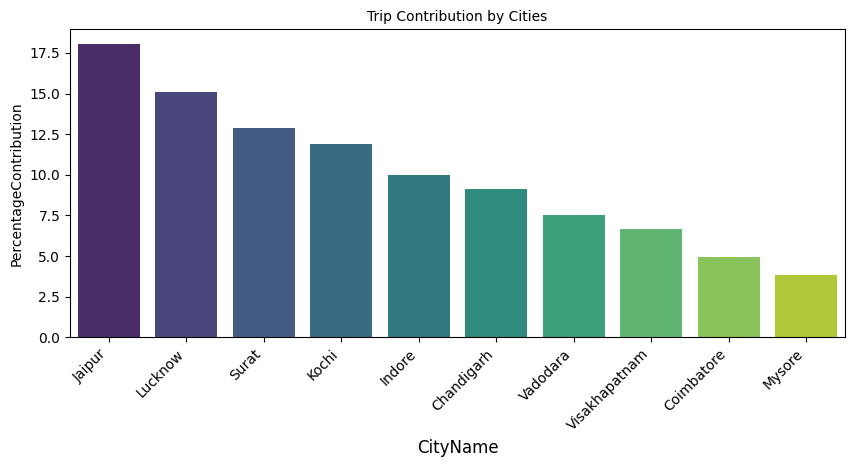

In [8]:
""" 1. City-level Fare and Trip Summary Report """

fact_trips_repartitioned = df_fact_trips.repartition("city_id")  # Partition by city_id for better distribution
fact_trips_repartitioned.createOrReplaceTempView("fact_trips_repartitioned")

# Cache the DataFrame for improved performance
fact_trips_repartitioned.cache()

# Running the query
Trip_summary_report = spark.sql("""

WITH TotalTrips AS (
    SELECT COUNT(t.trip_id) AS total_trips
    FROM fact_trips_repartitioned t
)

SELECT 
    c.city_name, 
    COUNT(t.trip_id) AS total_trips,
    ROUND(AVG(t.fare_amount / t.distance_travelled), 2) AS Avg_fare_per_km,
    ROUND(AVG(t.fare_amount), 2) AS Avg_fare_per_trip,
    ROUND(COUNT(t.trip_id) * 100.0 / (SELECT total_trips FROM TotalTrips), 2) AS Percentage_contribution_trips
FROM dim_city c 
JOIN fact_trips_repartitioned t
ON c.city_id = t.city_id
WHERE t.distance_travelled > 0  -- Avoiding division by zero
GROUP BY c.city_name
ORDER BY total_trips DESC                            
                           
""")

# Showing the results
Trip_summary_report.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_trip_summary_report = Trip_summary_report.toPandas()
plt.figure(figsize=(10,4))

Chart = sns.barplot(
    data = df_trip_summary_report,
    x= "city_name",
    y= "Percentage_contribution_trips",
    palette="viridis"
)

plt.title("Trip Contribution by Cities", fontsize = 10)
plt.xlabel("CityName", fontsize = 12)
plt.ylabel("PercentageContribution", fontsize = 10)
plt.xticks(rotation=45, ha='right')
plt.show()


In [9]:
""" 2. Monthly City-level Trips Target Performance Report"""

Month_city_level_trips = spark.sql (""" 
                                    
With AggregatedData as (

SELECT 
    c.city_name as cityname, 
    t.month_name as month, 
    COUNT(tt.trip_id) AS Actual_trips, 
    COALESCE(SUM( DISTINCT t.total_target_trips), 0) AS Target_trips
FROM 
    dim_city c 
JOIN 
    fact_trips tt ON c.city_id = tt.city_id
JOIN 
    target_trips t ON c.city_id = t.city_id AND date_format(tt.date, 'MMMM') = t.month_name
GROUP BY 
    c.city_name, t.month_name
ORDER BY 
    t.month_name
                                    
)
                                    
SELECT d.cityname, d.month, d.Actual_trips, d.Target_trips,
       CASE
            WHEN d.Actual_trips > d.Target_trips THEN "Above_Target"
            ELSE "Below_Target"
       END as Peformance_Status, ROUND(((d.Actual_trips - d.Target_trips)*100.0/ d.Target_trips),2) as Percent_Difference
FROM AggregatedData d
ORDER BY d.cityname, d.month
                                    
""")

Month_city_level_trips.show()

+----------+--------+------------+------------+-----------------+------------------+
|  cityname|   month|Actual_trips|Target_trips|Peformance_Status|Percent_Difference|
+----------+--------+------------+------------+-----------------+------------------+
|Chandigarh|   April|        5566|        6000|     Below_Target|             -7.23|
|Chandigarh|February|        7387|        7000|     Above_Target|              5.53|
|Chandigarh| January|        6810|        7000|     Below_Target|             -2.71|
|Chandigarh|    June|        6029|        6000|     Above_Target|              0.48|
|Chandigarh|   March|        6569|        7000|     Below_Target|             -6.16|
|Chandigarh|     May|        6620|        6000|     Above_Target|             10.33|
|Coimbatore|   April|        3661|        3500|     Above_Target|              4.60|
|Coimbatore|February|        3404|        3500|     Below_Target|             -2.74|
|Coimbatore| January|        3651|        3500|     Above_Target|

In [10]:
""" 3. City-level Repeat Passenger Trip Frequency Report """

Repeat_passenger_report = spark.sql("""
    SELECT 
        c.city_name,
        -- Calculating the total repeat passengers for each city
        SUM(r.repeat_passenger_count) AS total_repeat_passengers,
        
        -- Calculate percentage for each trip count
        ROUND(SUM(CASE WHEN r.trip_count = '2-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `2-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '3-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `3-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '4-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `4-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '5-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `5-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '6-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `6-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '7-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `7-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '8-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `8-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '9-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `9-Trips (%)`,
        ROUND(SUM(CASE WHEN r.trip_count = '10-Trips' THEN r.repeat_passenger_count ELSE 0 END) * 100.0 / 
              SUM(r.repeat_passenger_count), 2) AS `10-Trips (%)`
    FROM 
        dim_city c
    JOIN 
        dim_repeat_trip r
    ON 
        c.city_id = r.city_id
    GROUP BY 
        c.city_name
    ORDER BY 
        c.city_name
""")

# Displaying the report
Repeat_passenger_report.show()


+-------------+-----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
|    city_name|total_repeat_passengers|2-Trips (%)|3-Trips (%)|4-Trips (%)|5-Trips (%)|6-Trips (%)|7-Trips (%)|8-Trips (%)|9-Trips (%)|10-Trips (%)|
+-------------+-----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
|   Chandigarh|                   5070|      32.31|      19.25|      15.74|      12.21|       7.42|       5.48|       3.47|       2.33|        1.79|
|   Coimbatore|                   2551|      11.21|      14.82|      15.56|      20.62|      17.64|      10.47|       6.15|       2.31|        1.22|
|       Indore|                   7216|      34.34|      22.69|      13.40|      10.34|       6.85|       5.24|       3.26|       2.38|        1.51|
|       Jaipur|                   9682|      50.14|      20.73|      12.12|       6.29|       4.13|       

In [11]:
""" 4. Identifying Cities with Lowest and Highest Total New Passengers"""

spark.sparkContext.setLogLevel("ERROR")

new_total_passengers = spark.sql (""" 
                                  
WITH RankedCities AS (

SELECT c.city_name as CityName, SUM(ps.new_passengers) as Total_new_passengers,
        RANK() OVER(ORDER BY SUM(ps.new_passengers) DESC) AS rank_high,
        RANK() OVER(ORDER BY SUM(ps.new_passengers)) AS rank_low
        FROM dim_city c JOIN fact_passenger_summary ps
        ON c.city_id = ps.city_id
        GROUP BY c.city_name
),

 TopBottomCities AS (

SELECT CityName, Total_new_passengers,
       CASE 
        WHEN rank_high<=3 THEN 'Top 3'
        WHEN rank_low<=3 THEN 'Bottom 3'
        ELSE Null
       END AS Category
    FROM RankedCities
)   
                           
SELECT CityName, Total_new_passengers, Category FROM TopBottomCities
       WHERE Category IS NOT NUll
       ORDER BY Total_new_passengers DESC
                                  
 """)

new_total_passengers.show()


+----------+--------------------+--------+
|  CityName|Total_new_passengers|Category|
+----------+--------------------+--------+
|    Jaipur|               45856|   Top 3|
|     Kochi|               26416|   Top 3|
|Chandigarh|               18908|   Top 3|
|     Surat|               11626|Bottom 3|
|  Vadodara|               10127|Bottom 3|
|Coimbatore|                8514|Bottom 3|
+----------+--------------------+--------+



In [12]:
df_fact_trips = df_fact_trips.withColumn("month", date_format('date', 'MMMM'))

df_fact_trips.createOrReplaceTempView("fact_trips")

In [13]:
""" 5. Month with Highest Revenue for Each City"""

highest_revenue_citywise = spark.sql(""" 

WITH RevenueTable AS (                                                                                                            
  SELECT c.city_name as CityName, SUM(t.fare_amount) as HighestRevenue,
        DENSE_RANK() OVER(PARTITION BY c.city_name ORDER BY SUM(t.fare_amount) DESC) AS Rank,
        t.month as Month
        FROM dim_city c JOIN fact_trips t
        ON c.city_id = t.city_id
        GROUP BY c.city_name, t.month
        ORDER BY c.city_name ASC
),
                                
    TotalRevenue AS (
        SELECT SUM(fare_amount) as Total_Revenue FROM fact_trips                                                                                                             
)
                                     
SELECT CityName, Month, HighestRevenue,
       ROUND((HighestRevenue / 1000000),2) as In_Mil,
       ROUND((HighestRevenue/(SELECT Total_Revenue FROM TotalRevenue)*100), 2) as Percentage_Cont
       FROM RevenueTable
       WHERE Rank = 1
       ORDER BY Percentage_Cont DESC 
                                                                                                           
  """)

highest_revenue_citywise.show()

+-------------+--------+--------------+------+---------------+
|     CityName|   Month|HighestRevenue|In_Mil|Percentage_Cont|
+-------------+--------+--------------+------+---------------+
|       Jaipur|February|       7747202|  7.75|           7.16|
|        Kochi|     May|       3333746|  3.33|           3.08|
|   Chandigarh|February|       2108290|  2.11|           1.95|
|      Lucknow|February|       1777269|  1.78|           1.64|
|Visakhapatnam|   April|       1390682|  1.39|           1.29|
|       Indore|     May|       1380996|  1.38|           1.28|
|        Surat|   April|       1154909|  1.15|           1.07|
|       Mysore|     May|        745170|  0.75|           0.69|
|     Vadodara|   April|        706250|  0.71|           0.65|
|   Coimbatore|   April|        612431|  0.61|           0.57|
+-------------+--------+--------------+------+---------------+



In [20]:
df_fact_passenger_summary = df_fact_passenger_summary.withColumn("monthname", date_format('month','MMMM'))

df_fact_passenger_summary.createOrReplaceTempView("fact_passenger_summary")

In [44]:
""" 6. Repeat Passenger Rate Analysis (Monthly and City-wise) """

passenger_rate_analysis_monthly = spark.sql("""
                                            
WITH Passengers AS (
 SELECT c.city_name as CityName, ps.monthname as Month, SUM(ps.total_passengers) as TotalPassengers,
                    SUM(repeat_passengers) as RepeatPassengers
                    FROM dim_city c JOIN fact_passenger_summary ps
                    ON c.city_id = ps.city_id
                    GROUP BY c.city_name, ps.monthname                                                                                                                                                                                                                      
)                                            
SELECT p.CityName, p.Month,
       ROUND((p.RepeatPassengers*100/p.TotalPassengers),2) AS MonthlyRepeatPassengersCont
       FROM Passengers p
       ORDER BY p.CityName, p.Month
                                            
                              
  """)

passenger_rate_analysis_monthly.show()


passenger_rate_analysis_citywise = spark.sql(""" 

                                            
WITH CitywisePassengers AS (
SELECT c.city_name as CityName, SUM(ps.total_passengers) as TotalCityPassengers,
                    SUM(repeat_passengers) as TotalCityRepeatPassengers
                    FROM dim_city c JOIN fact_passenger_summary ps
                    ON c.city_id = ps.city_id
                    GROUP BY c.city_name                                                                                                                                   
)                                            
SELECT cwp.CityName,
       ROUND((cwp.TotalCityRepeatPassengers*100/cwp.TotalCityPassengers),2) AS CityRepeatPassengersCont
       FROM CitywisePassengers cwp
       ORDER BY cwp.CityName

 """)

passenger_rate_analysis_citywise.show()


+----------+--------+---------------------------+
|  CityName|   Month|MonthlyRepeatPassengersCont|
+----------+--------+---------------------------+
|Chandigarh|   April|                      24.02|
|Chandigarh|February|                      17.21|
|Chandigarh| January|                      15.52|
|Chandigarh|    June|                       26.3|
|Chandigarh|   March|                      21.27|
|Chandigarh|     May|                       26.2|
|Coimbatore|   April|                      27.87|
|Coimbatore|February|                      17.36|
|Coimbatore| January|                      17.71|
|Coimbatore|    June|                      24.69|
|Coimbatore|   March|                      21.73|
|Coimbatore|     May|                      32.66|
|    Indore|   April|                      35.52|
|    Indore|February|                      27.71|
|    Indore| January|                      26.65|
|    Indore|    June|                      35.88|
|    Indore|   March|                      28.46|
